# 5 - Value at Risk (VaR)

Espen Sirnes  
2025-08-10

# VaR

Value at Risk, commonly known as VaR, is a foundational concept in risk
management, widely used by financial institutions to quantify and
control risk exposure (Morgan and Reuters 1996). Essentially, VaR
answers the question, *“What is the maximum potential loss over a given
time period within a specified confidence interval?”* The confidence
interval here represents the range within which we expect a certain
percentage of returns to fall. For instance, with a 95% confidence
interval, we anticipate that only 5% of cases will breach this lower
threshold. The closer the model’s expected breaches are to the actual
empirical frequency, the better the model’s accuracy.

VaR provides a standardized way to assess risk, helping firms to
understand potential losses and allocate capital effectively (Jorion
2007). Regulators also rely heavily on VaR; in fact, this method is
embedded directly in EU financial regulations, requiring banks to hold
capital reserves proportional to their risk exposure (Ong 2007). By
setting a standardized measure for risk, VaR supports financial
stability and resilience, making it invaluable for both risk managers
and regulators.

In this lecture, we’ll see that VaR is not a single, fixed method. Its
accuracy and effectiveness depend on one crucial element: how volatility
is predicted. Different approaches to forecasting volatility result in
varying VaR outcomes, each with its strengths and limitations. By
exploring these nuances, we’ll gain a deeper understanding of both the
power and the limitations of VaR as a risk management tool.

We start by loading the data from lecture 3:

In [1]:
import pandas as pd
df = pd.read_pickle('data/X.df')
df

507 rows × 5 columns

# Backtesting VaR

To understand the effectiveness of Value at Risk (VaR), we can test its
accuracy by evaluating actual financial data and examining how well
different VaR models predict risk.

Specifically, VaR is expected to forecast a certain number of
“breaches”—cases where the return falls below the calculated lower
bound—relative to the total sample of returns. The closer the model’s
predictions align with the actual frequency of breaches, the more
reliable the model is.

To carry out this backtest, we’ll define a function to calculate VaR for
historical returns from a financial time series. The function takes the
following inputs: - A general function, `f(x, sigmalist)`, which
calculates the 95% and 99% VaR and returns an updated volatility (if
applicable). This function uses historical data `x` and past volatility
`sigmalist`. The specific function provided will determine the method
used for VaR calculation. - A `pandas` DataFrame `df` containing
historical data. - The name of the data series in `df`. - An estimation
window, specifying the number of periods used to estimate the current
VaR.

The function will return: - The 95% and 99% VaR for each date, - The
estimated volatility (if applicable), - The corresponding dates, - The
associated returns.

Below is the function for generating the backtest:

In [2]:
import numpy as np
def generate_backtest(f, df, name, estimation_win_size):
    # Initialize lists to store calculated values
    datelist = []
    sigmalist = []
    d95list = []
    d99list = []
    ret = []

    # Iterate over returns to calculate and store VaR and volatility estimates
    for t in range(estimation_win_size, len(df)):
        
        # Record date and current return
        datelist.append(df.index[t].date())
        ret.append(df[name].iloc[t])

        # Extract data from the estimation window (t-estimation_win_size to t-1)
        x = df[name].iloc[t-estimation_win_size:t-1]

        # Apply the provided VaR estimation function using the historical data and past volatility
        d95, d99, sigma = f(x, sigmalist)

        # Append the estimates to their respective lists
        sigmalist.append(sigma)
        d95list.append(d95)
        d99list.append(d99)

    # Return the results as numpy arrays for ease of analysis
    return (np.array(d95list),
            np.array(d99list),
            np.array(sigmalist),
            np.array(datelist),
            np.array(ret))

This setup allows for a flexible approach to testing different VaR
models by simply passing different VaR estimation functions into
`generate_backtest`. The returned data can then be used to evaluate the
model’s effectiveness by comparing predicted breaches against actual
outcomes.

# Evaluation Function

After generating the VaR time series, we need an `evaluate` function to
assess the model’s effectiveness. This function will take the following
arguments: - A plot object `plt` to visualize the performance, - The
estimated 95% and 99% VaR series, - The returns, - The dates, - A
heading for the plot.

The function will produce an informative graph with bars wher there are
breaches, and display the model’s performance by calculating the
percentage of breaches. Here’s the function:

In [3]:
import matplotlib.pyplot as plt
def evaluate(plt, d95, d99, ret, dates, heading):
    # Clear the plot area to avoid overlapping plots
    plt.cla()

    # Plot the 95% VaR, 99% VaR, and actual returns
    plt.plot(dates, d95, label='95% Confidence Level')
    plt.plot(dates, d99, label='99% Confidence Level')
    plt.plot(dates, ret, label='Actual Return')

    # Highlight instances where returns breach the 95% VaR
    maxret = max(ret)
    breaches_95 = [maxret if d > r else 0 for d, r in zip(d95, ret)]
    plt.bar(dates, breaches_95, color='gray', alpha=0.5, width=0.5, label='Breaches 95% VaR')

    # Set labels and title
    plt.ylabel('VaR')
    plt.xlabel('Date')
    plt.title(heading)
    plt.xticks(rotation=90)
    plt.legend(loc="lower right")
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Calculate and print the breach percentage for each confidence level
    backtest_results = [np.round(sum(d > ret) / len(ret) * 100, 1) for d in [d95, d99]]

    for i, level in enumerate([95, 99]):
        breaches = sum([d95, d99][i] > ret)
        print(f"{heading} with {level}% confidence interval:\n"
              f"Breaches: {breaches}\n"
              f"Backtesting (Realized VaR - % breaches): {backtest_results[i]}%\n")

This function provides a visual and numerical evaluation of VaR
accuracy. The plot shows the 95% and 99% VaR levels alongside the actual
returns, with breaches of the 95% VaR highlighted. The function then
calculates and prints the percentage of breaches, allowing us to assess
how well the model aligns with expected outcomes.

# Methods for Calculating VaR

Calculating Value at Risk (VaR) fundamentally involves predicting
volatility. A model that can accurately predict volatility will yield a
more reliable VaR estimate. Here, we’ll explore three different methods
for calculating VaR: using the normal distribution, empirical
frequencies, and past volatility.

## The Normal Distribution Model

The most straightforward approach is to assume that returns follow a
normal distribution. We can estimate the standard deviation (volatility)
of a sample `x` and apply the normal distribution to compute VaR. That
in practice just means multiplying the volatility with a number
corresponding to the confidence interval, in this case given by the
function `norm.ppf(PVALS)`. This is implemented as follows

In [4]:
PVALS = [0.05, 0.01]  # Confidence intervals (95% and 99%)
from scipy.stats import norm

def normal_est(x, sigmalist):
    z = norm.ppf(PVALS)  # Z-scores for the specified confidence levels
    sigma = np.std(x, ddof=1)  # Sample standard deviation
    return z[0] * sigma, z[1] * sigma, sigma

The global variable `PVALS` sets the confidence levels, making it easy
to adjust later, though 95% and 99% are almost always used in practice.

## Empirical Frequencies

An alternative method is to rely on empirical data, using historical
quantiles to set the VaR thresholds. This method establishes limits that
would have perfectly predicted historical data breaches at the 95% and
99% levels:

In [5]:
def historical_est(x, sigmalist):
    q95 = abs(np.quantile(x, PVALS[0]))  # 95th percentile of historical losses
    q99 = abs(np.quantile(x, PVALS[1]))  # 99th percentile of historical losses
    return -q95, -q99, None  # VaR values are negative to indicate potential loss

This approach is straightforward and does not assume any specific
distribution of returns.

## Past Volatility

A third method involves modeling volatility based on its past behavior.
Using only the volatility from the previous period would imply constant
volatility, so we introduce an innovation term—specifically, the squared
error from the previous period. This error is added to the previous
period’s variance and then square-rooted to estimate current volatility.
If no prior volatility exists (e.g., in the first period), historical
volatility is used.

After estimating the volatility, we can use the normal distribution to
calculate VaR for each confidence interval. This type of
volatility-based VaR estimation is required for financial firms under EU
regulations (Banking Supervision 1996).

In [6]:
def last_volat(x, sigmalist):
    x = np.array(x)
    z = norm.ppf(PVALS)
    if not sigmalist:  # If sigmalist is empty, use initial standard deviation
        sigma = np.std(x, ddof=1)
    else:  # Update sigma based on past volatility and recent error
        sigma = (0.1 * (x[0] - np.mean(x))**2 + 0.9 * sigmalist[-1]**2)**0.5
    return z[0] * sigma, z[1] * sigma, sigma

These methods offer varied approaches to calculating VaR, each with
specific strengths: the normal model assumes a normal distribution,
empirical quantiles base predictions on historical breaches, and the
volatility-based method adjusts dynamically, often aligning with
regulatory requirements.

# Evaluation

We can now easily evaluate the different methods. We first evalueat
under the normal distribution.

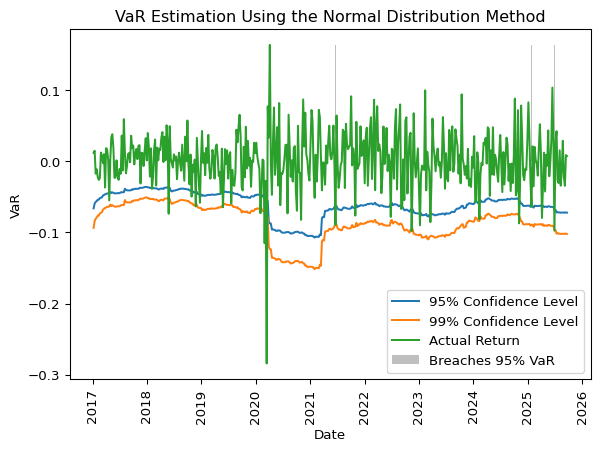

VaR Estimation Using the Normal Distribution Method with 95% confidence interval:
Breaches: 25
Backtesting (Realized VaR - % breaches): 5.5%

VaR Estimation Using the Normal Distribution Method with 99% confidence interval:
Breaches: 10
Backtesting (Realized VaR - % breaches): 2.2%


In [7]:
NAME = 'EQNR'
ESTIMATION_WINSIZE = 52

(normal95, normal99, 
 sigma, dates, ret )= generate_backtest(normal_est, 
        df, NAME, ESTIMATION_WINSIZE)
evaluate(plt, normal95, normal99, ret, dates,
         'VaR Estimation Using the Normal Distribution Method')

Then we apply the function that simply calculates the empirical
distribution of passed returns:

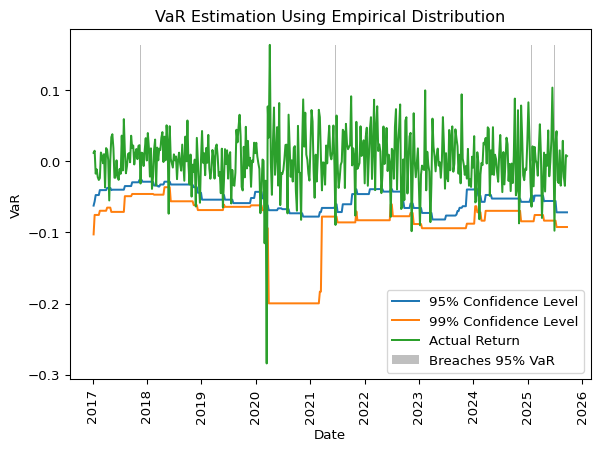

VaR Estimation Using Empirical Distribution with 95% confidence interval:
Breaches: 32
Backtesting (Realized VaR - % breaches): 7.0%

VaR Estimation Using Empirical Distribution with 99% confidence interval:
Breaches: 13
Backtesting (Realized VaR - % breaches): 2.9%


In [8]:
(hist95, hist99, 
 sigma, dates, ret )= generate_backtest(historical_est, 
        df, NAME, ESTIMATION_WINSIZE)
evaluate(plt, hist95, hist99, ret, dates,
         'VaR Estimation Using Empirical Distribution')

And at last, we use information about the previous period volatility.

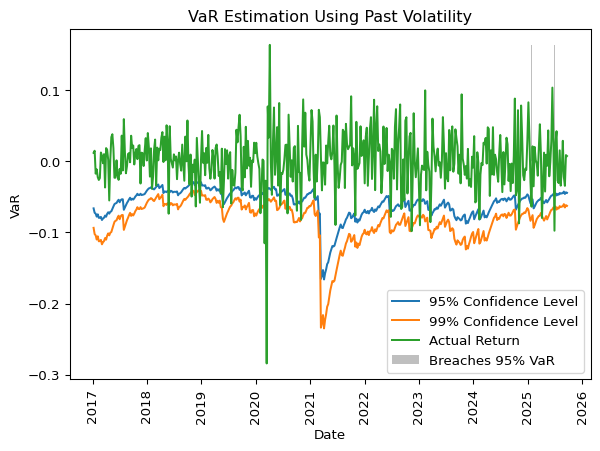

VaR Estimation Using Past Volatility with 95% confidence interval:
Breaches: 27
Backtesting (Realized VaR - % breaches): 5.9%

VaR Estimation Using Past Volatility with 99% confidence interval:
Breaches: 14
Backtesting (Realized VaR - % breaches): 3.1%


In [9]:
(last95, last99, 
 sigma, dates, ret )= generate_backtest(last_volat, 
        df, NAME, ESTIMATION_WINSIZE)
evaluate(plt, last95, last99, ret, dates,
         'VaR Estimation Using Past Volatility')

# Concluding Remarks

VaR (Value at Risk) provides an effective framework for communicating
risk and has undoubtedly become the standard for measuring and
controlling market risk. However, its ability to capture real risk
depends heavily on its implementation. Risk is not static; it evolves
continuously, responding to changing market conditions and external
factors.

Dynamic measures can help anticipate shifts in risk, but as we have seen
from the examples, they do not always outperform static measures.
Predicting changes in risk is inherently challenging, and no single
approach guarantees accurate foresight.

A notable example of these limitations is the case of Long-Term Capital
Management (LTCM) (Lowenstein 2000). LTCM was managed by some of the
brightest minds in finance, including Nobel laureates Myron Scholes and
Robert C. Merton, the inventors of the renowned option pricing formula.
Despite their reliance on VaR and a perception that their portfolios
were robust and healthy, the Asian financial crisis of 1997 exposed
critical flaws in their risk models. The models proved inadequate
against unforeseen events, and the fund ultimately had to be liquidated
in early 2000.

These experiences serve as a stark reminder that VaR cannot be used
uncritically. If a portfolio cannot be rebalanced quickly enough to
adapt to shifting market conditions and declining liquidity, VaR offers
little protection.

A skilled risk manager must also guard against the manipulation of VaR.
Portfolio managers can exploit the model by selecting securities with
hidden risks that VaR calculations fail to capture. A striking example
is the Norwegian Oil Fund manager who reportedly earned bonuses
amounting to nearly half a billion NOK, seemingly by taking significant
risks (Dahl 2010).

High-risk investments often promise high returns, and employees with
compensation structures linked to bonuses—without corresponding
penalties for losses—are incentivized to take on excessive risk. Such
arrangements function like an asymmetric option: they allow individuals
to benefit from the upside while avoiding equivalent downside losses,
fostering a strong incentive to maximize risk.

To address these challenges, a good risk manager works to minimize
opportunities for such manipulation while maintaining vigilance for
unobservable risk factors. Managing risk is not just about tools like
VaR; it requires judgment, adaptability, and a proactive approach to
identifying and mitigating hidden risks.

# Literature

Banking Supervision, Basel Committee on. 1996. “Amendment to the Capital
Accord to Incorporate Market Risks.” Bank for International Settlements.

Dahl, Carl Alfred. 2010. “Svenske Fikk Halv Milliard Av Oljefondet.”
*Aftenposten*.
<https://www.aftenposten.no/okonomi/i/pA656/svenske-fikk-halv-milliard-av-oljefondet>.

Jorion, Philippe. 2007. *Value at Risk: The New Benchmark for Managing
Financial Risk*. 3rd ed. McGraw-Hill.

Lowenstein, Roger. 2000. *When Genius Failed: The Rise and Fall of
Long-Term Capital Management*. Random House.

Morgan, J. P., and Reuters. 1996. “RiskMetrics — Technical Document.”
J.P. Morgan/Reuters.

Ong, Michael K. 2007. *The Basel Handbook: A Guide for Financial
Practitioners*. 2nd ed. Risk Books.